In [2]:
import pandas as pd
from pathlib import Path
import tensorflow as tf
path = Path("C:\\Users\\manch\\OneDrive\\Documents\\DEV\\MachineLearning\\datasets\\CTA_-_Ridership_-_Daily_Boarding_Totals_20241230.csv")

df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"] #shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1) # no need for total, it's just bus+ rail
df = df.drop_duplicates() # remove duplicated months (2011-10and 2014-07)
df

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
...,...,...,...
2024-10-27,U,312965,215594
2024-10-28,W,611041,389359
2024-10-29,W,652674,444706


In [3]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1,drop_remainder=True)
    return dataset.flat_map(lambda window_ds:window_ds.batch(length))

def to_seq2seq_dataset( series, 
                        seq_length=56, 
                        ahead=14,
                        target_col=1,
                        batch_size=32, 
                        shuffle=False, 
                        seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series),ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:,1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)


In [4]:
import tensorflow as tf
import numpy as np

df_mulvar                   = df[["bus", "rail"]] / 1e6 # use both bus & rail series as input
df_mulvar["next_day_type"]  = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar                   = pd.get_dummies(df_mulvar) # one-hot encode the day type Now df_mulvar is a DataFrame with five columns: the bus and rail data,
                                                        # plus three columns containing the one-hot encoding of the next day’s type
                                                        # (recall that there are three possible day types, W, A, and U).

#Split the data into three periods. For training, validation, and testing:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test  = df_mulvar["2019-06":]

# Ensure all columns are numeric, converting booleans to float32
mulvar_train = mulvar_train.astype(np.float32)
mulvar_valid = mulvar_valid.astype(np.float32)
mulvar_test  = mulvar_test.astype(np.float32)

In [6]:

conv_rnn_model = tf.keras.Sequential(
                                        [
                                            tf.keras.layers.Conv1D( filters=32, 
                                                                    kernel_size=4, 
                                                                    strides=2,
                                                                    activation="relu", 
                                                                    input_shape=[None,5]
                                                                    ),
                                            tf.keras.layers.GRU(32, return_sequences=True),
                                            tf.keras.layers.Dense(14)
                                        ]
                                    )
longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)

downsampled_train = longer_train.map(lambda X, Y: (X, Y[:,3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:,3::2]))


C:\Users\manch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

conv_rnn_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt,metrics=["mae"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)

history_conv_rnn_model    =   conv_rnn_model.fit(
                                                downsampled_train, 
                                                validation_data=downsampled_valid,
                                                epochs=500,
                                                callbacks=[early_stopping_cb]
        )
# Get MAE values for training and validation
mae_values = history_conv_rnn_model.history['mae']  # training MAE
val_mae_values = history_conv_rnn_model.history['val_mae']  # validation MAE

# Get loss values
loss_values = history_conv_rnn_model.history['loss']  # training loss
val_loss_values = history_conv_rnn_model.history['val_loss']  # validation loss


Epoch 1/500


     31/Unknown 9s 62ms/step - loss: 0.1402 - mae: 0.4636

C:\Users\manch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.1384 - mae: 0.4592 - val_loss: 0.0258 - val_mae: 0.1624
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0191 - mae: 0.1558 - val_loss: 0.0183 - val_mae: 0.1534
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0168 - mae: 0.1557 - val_loss: 0.0178 - val_mae: 0.1495
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0163 - mae: 0.1536 - val_loss: 0.0174 - val_mae: 0.1467
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0158 - mae: 0.1507 - val_loss: 0.0170 - val_mae: 0.1445
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0153 - mae: 0.1480 - val_loss: 0.0165 - val_mae: 0.1422
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0149 - mae: 0.1458 - val_loss: 0.0161 - val_mae: 0.1401
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0146 - mae: 0.1438 - val_loss: 0.0157 - val_mae: 0.1377
Epoch 9/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0141

TypeError: 'module' object is not callable

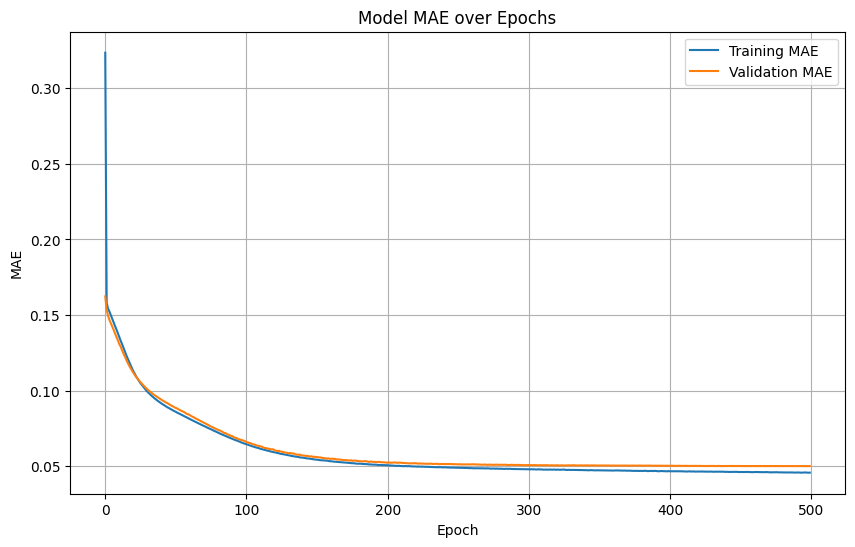

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(mae_values, label='Training MAE')
plt.plot(val_mae_values, label='Validation MAE')
plt.title('Model MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()



In [24]:
# Get predictions from the model
test_predictions = conv_rnn_model.predict(downsampled_valid)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


In [35]:
test_predictions.shape

(26, 55, 14)

In [53]:
# Downsample predictions
downsampled_predictions = test_predictions[:, :, 3::2]  # Match downsampling in validation targets
# Flatten predictions and targets
flattened_predictions = downsampled_predictions.reshape(-1)*1e6
flattened_targets = np.concatenate([y.numpy() for _, y in downsampled_valid])[:, :, 3::2].reshape(-1)*1e6



In [54]:
print(flattened_predictions.shape)  # Should match flattened_targets.shape
print(flattened_targets.shape)


(8580,)
(8580,)
(26, 55, 14)


In [55]:
mae = np.mean(np.abs(flattened_predictions - flattened_targets))
print("MAE:", mae)


MAE: 49399.09


In [18]:
# Get predictions
test_predictions = conv_rnn_model.predict(downsampled_valid)

# Since we're using a sequence length of 56, our predictions start at index 56
# We need to align the predictions with the actual values
actual_values = mulvar_valid["rail"][112:].values
#mae_1 = (pd.DataFrame(test_predictions*1e6) - pd.DataFrame(actual_values*1e6)).abs().mean() 
#print(mae_1)
actual_values.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


C:\Users\manch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


(39,)

ValueError: x and y can be no greater than 2D, but have shapes (26,) and (26, 55, 14)

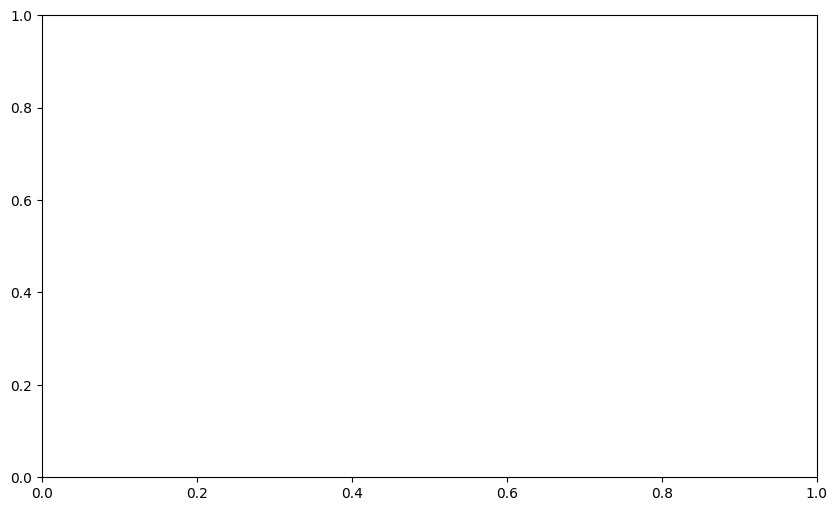

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_predictions, label='Predicted values')
plt.plot(actual_values, label='Actual Values')
plt.title('Model MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.Input(shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(
                        tf.keras.layers.Conv1D(
                                                filters=32, 
                                                kernel_size=2, 
                                                padding="causal",
                                                activation="relu",
                                                dilation_rate=rate
                                                )
                        )
    wavenet_model.add(tf.keras.layers.Conv1D(filters=14,kernel_size=1))
